In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import traceback
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from urllib.parse import urlparse
import re
from bs4 import BeautifulSoup
import requests

In [3]:
df = pd.read_csv('Phishing_Legitimate_full.csv')
df.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [4]:
missing_percentage = df.isna().sum()/len(df)*100

In [5]:
df = df.drop('id', axis=1)

In [6]:
# for column in df.columns:
#     sns.boxplot(data=df, x=column)
#     plt.show()

In [7]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [8]:
def correlation(data_df, threshold):
    corr_col = set()
    corr_matrix = data_df.corr()
    # print(corr_matrix)

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if(np.abs(corr_matrix.iloc[(i, j)]) > threshold):
                corr_col.add(corr_matrix.columns[j])

    return corr_col

corr_col = correlation(x_train, threshold=0.9)
x_train = x_train.drop(columns=corr_col, axis=1)
x_test = x_test.drop(columns=corr_col, axis=1)

In [9]:
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [10]:
scaler_x_minmax = MinMaxScaler()

In [11]:
def scaling(x1, scaler_x):
    x1 = scaler_x.fit_transform(x1)
    return x1, scaler_x

In [12]:
x_train1, scaler_x_minmax = scaling(x_train, scaler_x_minmax)

In [13]:
x_test1, scaler_x_minmax = scaling(x_test, scaler_x_minmax)

# **SVM**

In [14]:
# start_time = time.time()

# model = SVC(probability=False)
# model.fit(x_train1, y_train)

# end_time = time.time()
# training_time = end_time - start_time

# y_pred = model.predict(x_test1)

# print(f'Training Time: {training_time:.4f} seconds')
# print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
# print(f'Recall: {recall_score(y_test, y_pred)}')
# print(f'Precision: {precision_score(y_test, y_pred)}')
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# **Random Forest**

In [15]:
# start_time = time.time()

# model = RandomForestClassifier()
# model.fit(x_train1, y_train)

# end_time = time.time()
# training_time = end_time - start_time

# y_pred = model.predict(x_test1)
# y_pred_proba = model.predict_proba(x_test1)[:, 1]

# print(f'Training Time: {training_time:.4f} seconds')
# print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
# print(f'Recall: {recall_score(y_test, y_pred)}')
# print(f'Precision: {precision_score(y_test, y_pred)}')
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# **Grid SearchCV**

In [16]:
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', {0:1, 1:20}],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 9],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
    "KNeighborsClassifier" : {
        "n_neighbors": np.arange(1,20) ,
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan', 'minkowski'],
        "p": [1, 2]
    }
}

In [17]:
models = {
    "KNeighborsClassifier": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [18]:
# # GridSearchCV pour chaque modèle
# best_models = {}
# for name, model in models.items():
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     grid = GridSearchCV(model, param_grids[name], cv=skf, n_jobs=-1)
#     grid.fit(x_train1, y_train)
#     best_models[name] = grid.best_estimator_

#     print(f" Meilleurs paramètres pour {name} : {grid.best_params_}")

In [19]:
def evaluate(model, name_model):
    model.fit(x_train1, y_train)
    y_pred = model.predict(x_test1)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    # cv = ShuffleSplit(5, test_size=0.2)
    cv = StratifiedKFold(5)
    N, train_score, val_score = learning_curve(model, x_train1, y_train, cv=cv, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='val_score')
    plt.title(name_model)
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

# **Meilleur Model**

In [20]:
# for name, model in best_models.items():
#     print(name)
#     evaluate(model, name)

In [21]:
# joblib.dump(mmodel, 'C:\\Users\\Thibaut\\Documents\\MLProject\\url_pishing_classification\\xgboost_model.pkl')
# joblib.dump(scaler_x_minmax, 'C:\\Users\\Thibaut\\Documents\\MLProject\\url_pishing_classification\\minmax_scaler.pkl')

In [22]:
mmodel = joblib.load('xgboost_model.pkl')
scaler_x_minmax = joblib.load('minmax_scaler.pkl')

[[ 961   15]
 [  10 1014]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       976
           1       0.99      0.99      0.99      1024

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



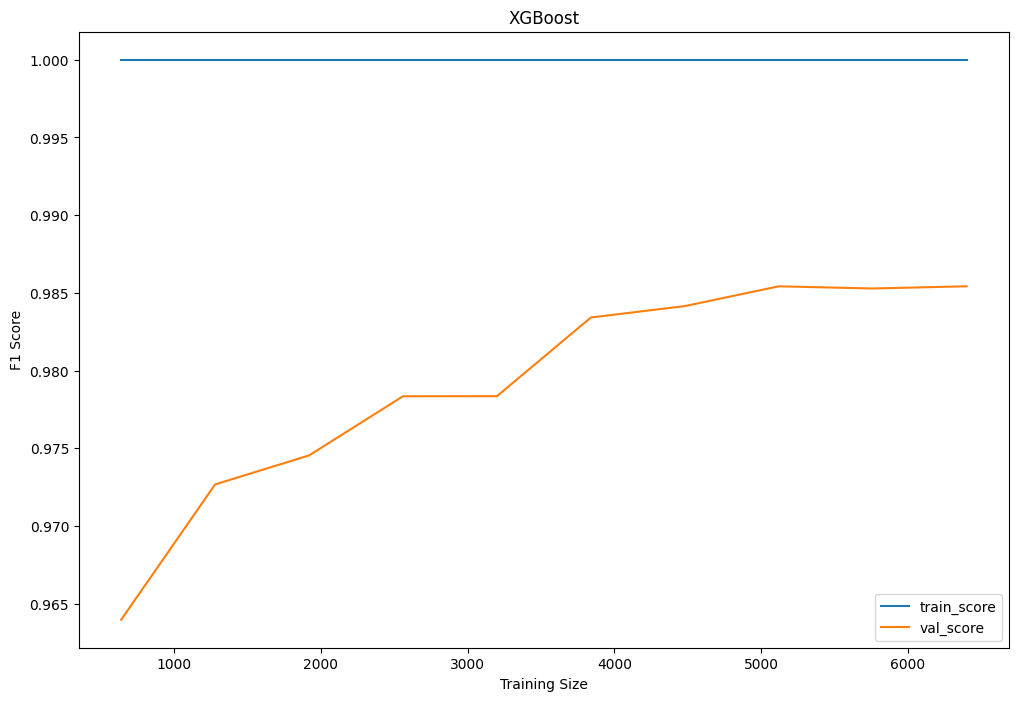

In [33]:
evaluate(mmodel, 'XGBoost')

In [24]:
feature_names = [
    'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
    'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
    'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
    'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
    'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
    'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
    'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
    'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
    'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
    'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
    'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
    'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
    'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
    'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
    'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT'
]

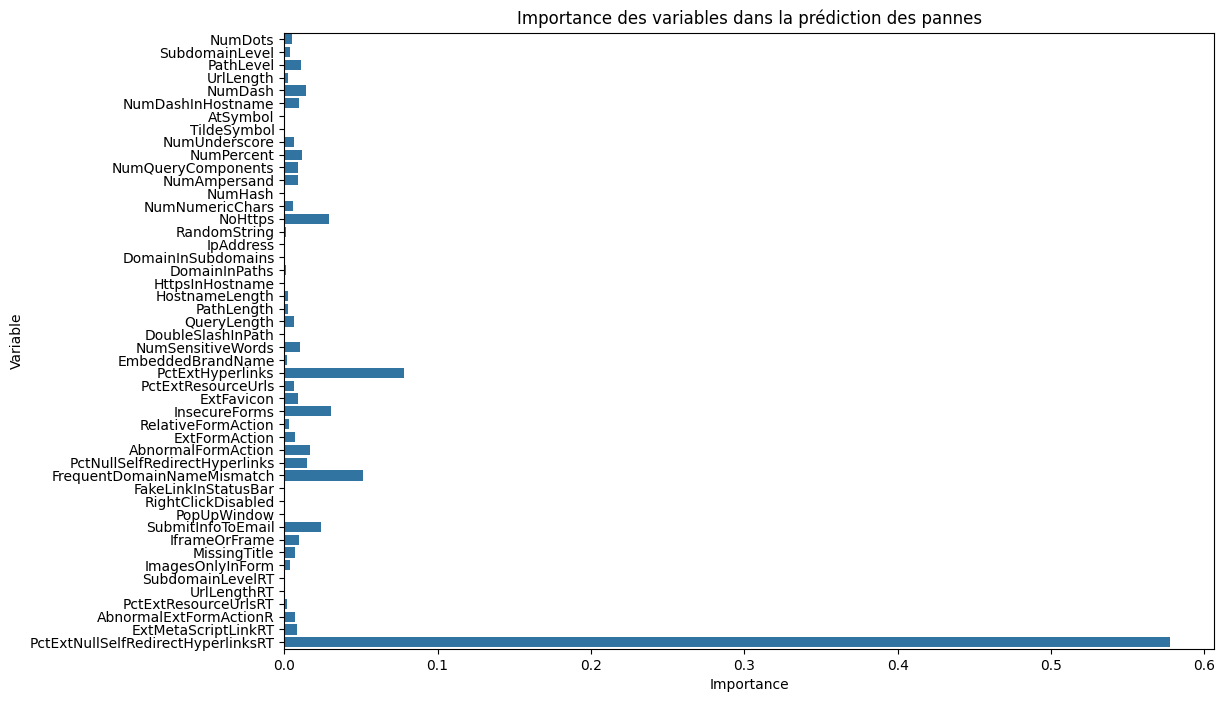

In [34]:
# Importance des features
plt.figure(figsize=(12, 8))
sns.barplot(x=mmodel.feature_importances_, y=feature_names)
plt.title('Importance des variables dans la prédiction des pannes')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.savefig('importance_variables.png')
plt.show()

# **Extraction des Caracteristiques**

In [26]:
def extract_features(url):
    features = {}

    # Analyser l'URL
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname or ''
    path = parsed_url.path or ''
    query = parsed_url.query or ''

    # Fonction de secours pour récupérer le HTML statique
    def get_html_fallback(url):
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
            response = requests.get(url, timeout=10, headers=headers)
            return response.text
        except Exception as e:
            print(f"Erreur dans get_html_fallback pour {url}: {str(e)}")
            return ""


    # Configurer Selenium pour Colab
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--remote-debugging-port=9222')
    chrome_options.add_argument('--disable-extensions')
    chrome_options.add_argument('--disable-setuid-sandbox')

    driver = None
    
    try:
        # Initialiser ChromeDriver
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
        driver.set_page_load_timeout(60)
        driver.get(url)
        WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.TAG_NAME, "form")))
        html_content = driver.page_source
        soup = BeautifulSoup(html_content, 'html.parser')
    
        if not html_content.strip():  # Vérifier si le contenu HTML est vide
            print(f"Contenu HTML vide récupéré pour {url} via Selenium, passage au fallback.")
            html_content = get_html_fallback(url)
            soup = BeautifulSoup(html_content, 'html.parser') if html_content else BeautifulSoup("", 'html.parser')
    except Exception as e:
        print(f"Erreur Selenium pour {url}: {e}")
        # Utiliser la solution de secours avec requests
        html_content = get_html_fallback(url)
        soup = BeautifulSoup(html_content, 'html.parser') if html_content else BeautifulSoup("", 'html.parser')
    finally:
        if driver is not None:
            driver.quit()

    try:
        # Extraire les caractéristiques
        features['NumDots'] = url.count('.')
        features['SubdomainLevel'] = len(hostname.split('.')) - 2 if hostname else 0
        features['PathLevel'] = len([p for p in path.split('/') if p])
        features['UrlLength'] = len(url)
        features['NumDash'] = url.count('-')
        features['NumDashInHostname'] = hostname.count('-')
        features['AtSymbol'] = 1 if '@' in url else 0
        features['TildeSymbol'] = 1 if '~' in url else 0
        features['NumUnderscore'] = url.count('_')
        features['NumPercent'] = url.count('%')
        features['NumQueryComponents'] = len(query.split('&')) if query else 0
        features['NumAmpersand'] = url.count('&')
        features['NumHash'] = 1 if '#' in url else 0
        features['NumNumericChars'] = sum(c.isdigit() for c in url)
        features['NoHttps'] = 0 if url.startswith('https') else 1
        features['RandomString'] = 1 if re.search(r'[a-zA-Z0-9]{20,}', url) else 0
        features['IpAddress'] = 1 if re.match(r'^(\d{1,3}\.){3}\d{1,3}$', hostname) and all(0 <= int(x) <= 255 for x in hostname.split('.')) else 0 # Vérification IP
        # features['IpAddress'] = 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', hostname) else 0
        features['DomainInSubdomains'] = 1 if any(brand in hostname for brand in ['paypal', 'amazon', 'bank']) else 0
        features['DomainInPaths'] = 1 if any(brand in path for brand in ['paypal', 'amazon', 'bank']) else 0
        features['HttpsInHostname'] = 1 if 'https' in hostname.lower() else 0
        features['HostnameLength'] = len(hostname)
        features['PathLength'] = len(path)
        features['QueryLength'] = len(query)
        features['DoubleSlashInPath'] = 1 if '//' in path else 0
        features['NumSensitiveWords'] = sum(1 for word in ['login', 'password', 'bank'] if word in url.lower())
        features['EmbeddedBrandName'] = 1 if any(brand in url.lower() for brand in ['paypal', 'amazon', 'bank']) else 0

        # Caractéristiques basées sur la page
        links = soup.find_all('a', href=True)
        total_links = len(links)
        ext_links = len([l for l in links if urlparse(l['href']).hostname and urlparse(l['href']).hostname != hostname])
        features['PctExtHyperlinks'] = ext_links / total_links if total_links > 0 else 0

        resources = soup.find_all(['img', 'script', 'link'], src=True)
        total_resources = len(resources)
        ext_resources = len([r for r in resources if urlparse(r['src']).hostname and urlparse(r['src']).hostname != hostname])
        features['PctExtResourceUrls'] = ext_resources / total_resources if total_resources > 0 else 0

        favicon = soup.find('link', rel='icon') or soup.find('link', rel='shortcut icon')
        if favicon:
            print(f"Favicon URL pour {url}: {favicon['href']}")
        features['ExtFavicon'] = 1 if favicon and urlparse(favicon['href']).hostname and urlparse(favicon['href']).hostname != hostname else 0

        forms = soup.find_all('form')
        features['InsecureForms'] = 1 if any(f.get('action') and not (f.get('action').startswith('https') or not urlparse(f.get('action')).scheme) for f in forms) else 0
        # features['InsecureForms'] = 1 if any(f.get('action') and not f.get('action').startswith('https') for f in forms) else 0
        features['RelativeFormAction'] = 1 if any(f.get('action') and not urlparse(f.get('action')).hostname for f in forms) else 0
        features['ExtFormAction'] = 1 if any(f.get('action') and urlparse(f.get('action')).hostname and urlparse(f.get('action')).hostname != hostname for f in forms) else 0
        features['AbnormalFormAction'] = 1 if any(f.get('action') in [None, '', 'javascript:void(0)'] for f in forms) else 0

        null_links = len([l for l in links if l['href'] in ['', '#', 'javascript:void(0)']])
        features['PctNullSelfRedirectHyperlinks'] = null_links / total_links if total_links > 0 else 0

        features['FrequentDomainNameMismatch'] = 1 if total_links > 0 and ext_links / total_links > 0.5 else 0
        features['FakeLinkInStatusBar'] = 1 if any('onmouseover' in str(l).lower() for l in links) else 0
        features['RightClickDisabled'] = 1 if 'contextmenu' in html_content.lower() else 0
        features['PopUpWindow'] = 1 if 'window.open' in html_content.lower() else 0
        features['SubmitInfoToEmail'] = 1 if any(f.get('action', '').startswith('mailto:') for f in forms) else 0
        features['IframeOrFrame'] = 1 if soup.find_all(['iframe', 'frame']) else 0
        features['MissingTitle'] = 1 if not soup.title else 0
        features['ImagesOnlyInForm'] = 1 if any(len(f.find_all('img')) > 0 and len(f.find_all(['input', 'textarea'])) == 0 for f in forms) else 0

        features['SubdomainLevelRT'] = 1 if features['SubdomainLevel'] > 2 else -1 if features['SubdomainLevel'] == 0 else 0
        features['UrlLengthRT'] = 1 if features['UrlLength'] > 100 else -1 if features['UrlLength'] < 50 else 0
        features['PctExtResourceUrlsRT'] = 1 if features['PctExtResourceUrls'] > 0.5 else -1 if features['PctExtResourceUrls'] < 0.1 else 0
        features['AbnormalExtFormActionR'] = features['ExtFormAction']
        features['ExtMetaScriptLinkRT'] = 1 if features['PctExtResourceUrls'] > 0.5 else -1 if features['PctExtResourceUrls'] < 0.1 else 0
        features['PctExtNullSelfRedirectHyperlinksRT'] = 1 if features['PctNullSelfRedirectHyperlinks'] > 0.5 else -1 if features['PctNullSelfRedirectHyperlinks'] < 0.1 else 0

    except Exception as e:
        print(f"Erreur lors de l'extraction des caractéristiques pour {url}: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Remplir avec des valeurs par défaut
        feature_names = [
            'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
            'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
            'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
            'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
            'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
            'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
            'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
            'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
            'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
            'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
            'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
            'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
            'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
            'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
            'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT'
        ]
        for key in feature_names:
            features[key] = features.get(key, 0)

    return features

In [27]:
# Fonction predict_phishing
def predict_phishing(url, model, scaler):
    features = extract_features(url)
    feature_names = [
        'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
        'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
        'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
        'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
        'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
        'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
        'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
        'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
        'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
        'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
        'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
        'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
        'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
        'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
        'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT'
    ]
    df = pd.DataFrame([features], columns=feature_names)
    df_scaled = scaler.transform(df)
    pred = model.predict(df_scaled)
    return url, 'Phishing' if pred == 1 else 'Légitime'

In [28]:


# Charger le modèle et le scaler
model = joblib.load('C:\\Users\\Thibaut\\Documents\\MLProject\\url_pishing_classification\\xgboost_model.pkl')
scaler = joblib.load('C:\\Users\\Thibaut\\Documents\\MLProject\\url_pishing_classification\\minmax_scaler.pkl')
print("Modèle et scaler chargés avec succès !")

Modèle et scaler chargés avec succès !


In [32]:
# Tester
url = "https://grok.com/chat/78c0c4e7-f0dd-4f46-ab6b-3ff63dc4c2cc"

predictions = predict_phishing(url, model, scaler)
features = extract_features(url)
print(f"{url}: {predictions}, Caractéristiques: {features}")

Erreur Selenium pour https://grok.com/chat/78c0c4e7-f0dd-4f46-ab6b-3ff63dc4c2cc: Message: 
Stacktrace:
	GetHandleVerifier [0x0xd03763+63299]
	GetHandleVerifier [0x0xd037a4+63364]
	(No symbol) [0x0xb31113]
	(No symbol) [0x0xb7987e]
	(No symbol) [0x0xb79c1b]
	(No symbol) [0x0xbc2212]
	(No symbol) [0x0xb9e5c4]
	(No symbol) [0x0xbbfa4a]
	(No symbol) [0x0xb9e376]
	(No symbol) [0x0xb6d6e0]
	(No symbol) [0x0xb6e544]
	GetHandleVerifier [0x0xf5e033+2531347]
	GetHandleVerifier [0x0xf59332+2511634]
	GetHandleVerifier [0x0xd29eda+220858]
	GetHandleVerifier [0x0xd1a528+156936]
	GetHandleVerifier [0x0xd20c5d+183357]
	GetHandleVerifier [0x0xd0b6c8+95912]
	GetHandleVerifier [0x0xd0b870+96336]
	GetHandleVerifier [0x0xcf664a+9770]
	BaseThreadInitThunk [0x0x76a57ba9+25]
	RtlInitializeExceptionChain [0x0x77cdc0cb+107]
	RtlClearBits [0x0x77cdc04f+191]

Erreur Selenium pour https://grok.com/chat/78c0c4e7-f0dd-4f46-ab6b-3ff63dc4c2cc: Message: 
Stacktrace:
	GetHandleVerifier [0x0xd03763+63299]
	GetHandleVerif

In [30]:
predictions

('https://grok.com/chat/78c0c4e7-f0dd-4f46-ab6b-3ff63dc4c2cc', 'Légitime')

In [31]:
# Sauvegarder les prédictions
results = pd.DataFrame([predictions], columns=['URL', 'Prédiction'])
results.to_csv('C:\\Users\\Thibaut\\Documents\\MLProject\\url_pishing_classification\\predictions.csv', index=False)
print("Prédictions sauvegardées avec succès !")

Prédictions sauvegardées avec succès !
